## Loads mouse tracking data, plots it and annotates social interactions

- A notebook for exploring the data and project structure.
- Also enables choosing appropriate annotation values.
- Inspiration mainly taken from the notebooks: "00-identify-neurons" and "ratemap" from this project.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import expipe
import pathlib
import numpy as np
import sys
sys.path.append('../ca2-mec')
import data_processing as dp
import spatial_maps as sp
import matplotlib.pyplot as plt

import exdir
%matplotlib inline

In [3]:
project_path = dp.project_path()
#project_path = '../../CA2prosjektmappe'
project = expipe.get_project(project_path)
actions = project.actions

In [4]:
def transform_coordinates(x, y):
    """
    Transform tracking coordinates to align with physical coordinates
    For this project (CA2 MEC): rotate recorded coordinates 90 degrees, 
    followed by a shift to make values positive afterwards.
    """
    # rotate x,y coordinates 90 degrees using a 2D rotation matrix transform
    theta = np.radians(90)
    r = np.array(( (np.cos(theta), -np.sin(theta)),
                   (np.sin(theta),  np.cos(theta)) ))
    coords = r @ np.array([x,y])
    # shift new x-coordinates to be positive
    coords = coords - np.min(coords, axis=-1, keepdims=True)
    # rescale coordinates to max 1
    coords = coords / np.max(coords, axis=-1, keepdims=True)
    return coords

def socializing(x, y, top, bottom, box_locations="TL+BR"):
    """
    Defines social boundaries of the box wrt. cardinal coordinates.
    
    Params:
        top, sequence-like (2,): 2d-coordinates for end of social boundary for
                                 the social-box at the top of the environment box
        bottom, sequence-like (2,): 2d-coordinates for end of social boundary
                                    the social-box at the bottom of the environment box
        box_locations, string: either: "TL+BR", i.e. TopLeft+BottomRight or 
                                       "TR+BL", i.e. TopRight+BottomLeft.
    """
    if box_locations == "TL+BR":
        # check which indices rat is inside social boundaries
        TL_social_mask = np.stack([x < top[0], y > top[1]],axis=-1)
        TL_social_mask = np.sum(TL_social_mask, axis=-1) == 2
        BR_social_mask = np.stack([x > bottom[0], y < bottom[1]],axis=-1)
        BR_social_mask = np.sum(BR_social_mask, axis=-1) == 2
        non_social_mask = ~(TL_social_mask | BR_social_mask) # boolean operations
        return TL_social_mask, BR_social_mask, non_social_mask
    elif box_locations == "TR+BL":
        # check which indices rat is inside social boundaries
        coords = np.stack([x,y],axis=-1)
        TR_social_mask = np.sum(coords > top, axis=-1) == 2
        BL_social_mask = np.sum(coords < bottom, axis=-1) == 2
        non_social_mask = ~(TR_social_mask | BL_social_mask) # boolean operations
        return TR_social_mask, BL_social_mask, non_social_mask
    else:
        print("Choose either 'TL+BR' or 'TR+BL' as box_locations")
        return None

In [252]:
# choose an action
action_id = '002-121220-5' 
action = actions[action_id]
print(action.attributes)
print(action.id, action.type)

max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size=0.02 #0.01
smoothing = 0.03 #0.05
baseline_duration = None  #600

data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=False, baseline_duration=baseline_duration,
)

# common values for all units == faster calculations
x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])
# transform according to box-setup
x, y = transform_coordinates(x, y)

{'registered': '2020-12-15T17:02:31', 'datetime': '2020-12-12T13:36:22', 'type': 'Recording', 'tags': ['open-ephys'], 'entities': ['002'], 'users': ['sarah'], 'location': 'ibv', 'data': {'main': 'actions\\002-121220-5\\data\\main.exdir'}}
002-121220-5 Recording


In [253]:
top, bottom = np.array([0.57,0.57]), np.array([0.43,0.43]) # 2d-array is (x,y) coordinates
box_locations = "TR+BL" # "TL+BR" or "TR+BL"
sm1, sm2, nsm = socializing(x=x, y=y, top=top, bottom=bottom, box_locations=box_locations)

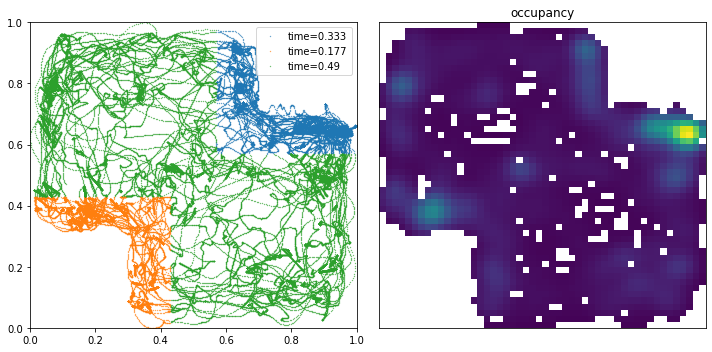

In [254]:
# calculate relative time spent in different parts of box
times = list(map(lambda x: np.sum(x), iter((sm1, sm2, nsm))))
fraction_times = np.around(np.array(times) / len(t), 3)

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
coords = np.stack([x,y],axis=-1)
axs[0].plot(*coords[sm1].T, 'o', markersize=0.3, label='time={}'.format(fraction_times[0]))
axs[0].plot(*coords[sm2].T, 'o', markersize=0.3, label='time={}'.format(fraction_times[1]))
axs[0].plot(*coords[nsm].T, 'o', markersize=0.3, label='time={}'.format(fraction_times[2]))
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].legend()

spatial_map = sp.SpatialMap(x, y, t, spike_times=np.array([]), box_size=1.0, bin_size=bin_size)
occupancy_map = spatial_map.occupancy_map(smoothing=smoothing, mask_zero_occupancy=True)
#occupancy_map = np.rot90(occupancy_map)
axs[1].imshow(occupancy_map.T, vmin=0, aspect="auto", origin='lower')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('occupancy')

plt.tight_layout()
# default is Downloads folder, but can use any folder :) 
#plt.savefig("/Users/sarahht/Downloads/denne.png") #evt .pdf